# Πρόβλεψη αποτελέσματος με βάση τα xGoals

Η συγκεκριμένη εφαρμογή θα εξετάσει αρχικά αν τα xGoals λένε τελικά την αλήθεια στο τελικό αποτέλεσμα ενός αγώνα και στη συνέχεια ποιο μοντέλο κατηγοριοποίησης μπορεί να προβλέψει καλύτερα αποτελέσματα αγώνων με βάση τα xGoals.

Τα δεδομένα αγώνων είναι από την ιστοσελίδα FBREF και αφορούν τα 4 καλύτερα πρωταθλήματα (Αγγλίας, Ισπανίας, Γερμανίας, Ιταλίας) με βάση την κατάταξη της UEFA και τις 6 τελευταίες σεζόν (2017-2023). Μετά από την κατάλληλη επεξεργασία, τα δεδομένα αποθηκεύτηκαν σε μορφή csv. Συνολικά είναι 8674 αγώνες.

## Εισαγωγή βιβλιοθηκών

In [1]:
# Οργάνωση και ανάλυση δεδομένων
import pandas as pd

# Αριθμητικοί υπολογισμοί σε πίνακες
import numpy as np

# Ορισμός μέγιστου αριθμού εμφανιζόμενων γραμμών και στηλών
pd.options.display.max_rows = 10000
pd.options.display.max_columns = 15

# Οπτικοποίηση δεδομένων
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# LabelEncoder
from sklearn import preprocessing

# Κατανομή των δεδομένων σε εκπαίδευσης και ελέγχου.
from sklearn.model_selection import train_test_split

# Decision Trees
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB

# Performance Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Cross Validation
from sklearn.model_selection import cross_val_score

## Ανάγνωση αρχείου δεδομένων τύπου csv

In [2]:
data=pd.read_csv('xGoals FBREF.csv')

## Μελέτη δεδομένων

#### Εμφάνιση διαστάσεων πίνακα όπου γραμμές=δείγματα και στήλες=χαρακτηριστικά

In [3]:
data.shape # 8674 δείγματα και 9 χαρακτηριστικά

(8674, 9)

#### Εμφάνιση των 5 πρώτων γραμμών δεδομένων

In [4]:
data.head()

,Date,Home,Away,Home_Goals,Away_Goals,Result,xG_Home,xG_Away,xG_Difference
0,2017-08-11,Arsenal,Leicester City,4,3,1,2.5,1.5,1.0
1,2017-08-12,Watford,Liverpool,3,3,0,2.1,2.6,-0.5
2,2017-08-12,Crystal Palace,Huddersfield,0,3,2,1.1,1.5,-0.4
3,2017-08-12,West Brom,Bournemouth,1,0,1,1.3,0.5,0.8
4,2017-08-12,Chelsea,Burnley,2,3,2,1.5,0.6,0.9


#### Εμφάνιση στατιστικών στοιχείων δεδομένων

In [ ]:
data.describe(include='all')

#### Εμφάνιση ονομάτος στηλών (χαρακτηριστικών)

In [ ]:
data.columns

#### Καταμέτρηση μοναδικών τιμών για συγκεκριμένα χαρακτηριστικά

In [5]:
xG_Distribution = data.xG_Difference.value_counts()
# xG_Distribution

<Axes: xlabel='xG_Difference', ylabel='Count'>

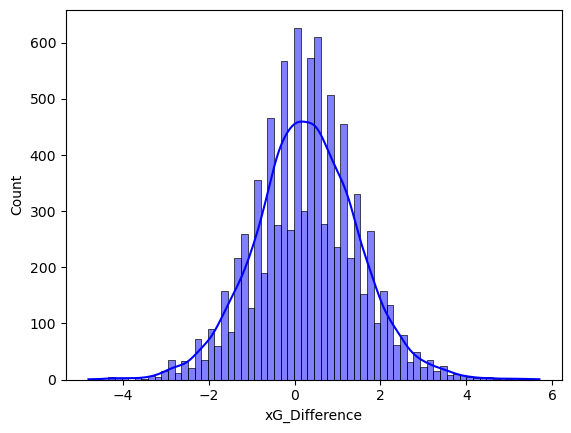

In [6]:
sns.histplot(data=data, x='xG_Difference', kde=True, color='blue')

Από το παραπάνω ιστόγραμμα φαίνεται ότι πολλοί αγώνες έχουν την τάση προς την τιμή xG_Difference=0. <br>
Αυτό σημαίνει ότι υπάρχουν οριακοί αγώνες όπου δεν υπάρχει ξεκάθαρη υπεροχή κάποιας ομάδας. Σύμφωνα με την KDE που αναδεικνύει την κατανομή των δεδομένων σε μια συνεχή κλίμακα τιμών, η μέγιστη τιμή της καμπύλης KDE βρίσκεται στο x=0.19. <br> Για αυτόν τον λόγο, θα ορίσουμε τους οριακούς αγώνες στο πεδίο 
[-0.2, 0.2], δηλαδή -0.2 ≤ xG_Difference ≤ 0.2.

#### Εκτίμηση Πυκνότητας Πυρήνα - Kernel Density Estimation (KDE)

Η εκτίμηση πυκνότητας πυρήνα αναδεικνύει την κατανομή των δεδομένων σε μια συνεχή κλίμακα τιμών.

Η μέγιστη τιμή της καμπύλης βρίσκεται στο x = 0.19


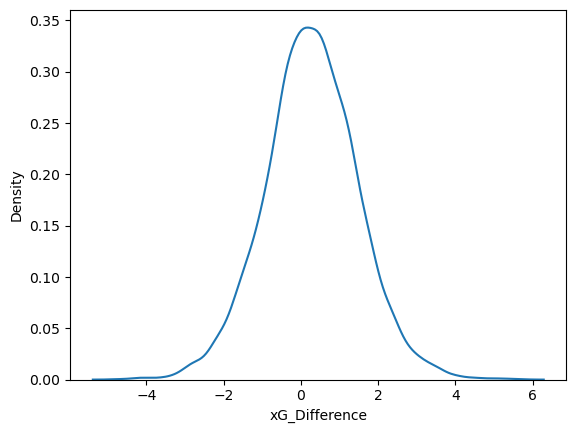

In [7]:
# Τιμές του x και του y για την καμπύλη KDE
x_values, y_values = sns.kdeplot(data['xG_Difference']).get_lines()[0].get_data()

# Εύρεση του αντίστοιχου x για τη μέγιστη τιμή του y
max_x = x_values[np.argmax(y_values)]

print("Η μέγιστη τιμή της καμπύλης βρίσκεται στο x =", round(max_x, 2))

#### Μέσος όρος xG_Difference

In [ ]:
mean_xG_Difference = data.xG_Difference.mean()
print("Ο μέσος όρος του xG_Difference είναι:", round(mean_xG_Difference, 2))

#### Μέσος όρος xG_Home και xG_Away


In [ ]:
data_mean_xG_Home = round((data['xG_Home'].mean()),2)
data_mean_xG_Away = round((data['xG_Away'].mean()),2)

print(f"Μ.Ο. xG_Home = {data_mean_xG_Home}")
print(f"Μ.Ο. xG_Away = {data_mean_xG_Away}")

#### Καταμέτρηση αποτελεσμάτων

In [8]:
data.Result.value_counts() # 3812 νίκες γηπεδούχου, 2709 νίκες φιλοξενούμενου και 2153 ισοπαλίες

1    3812
2    2709
0    2153
Name: Result, dtype: int64

<Axes: xlabel='Result', ylabel='Count'>

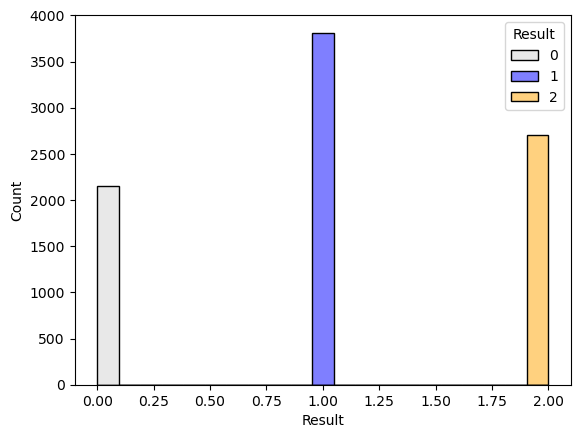

In [9]:
colors = {1: 'blue', 0: 'lightgrey', 2: 'orange'}

# Create the histogram with color mapping
sns.histplot(data=data, x='Result', hue='Result', palette=colors)
# sns.despine()

## Φιλτράρισμα πίνακα δεδομένων χρησιμοποιώντας συνθήκες

### 1. Υπεροχή γηπεδούχου (xG_Difference>0.2)

In [10]:
xG_positive = (data['xG_Difference'] > 0.2)
num_xG_positive = xG_positive.sum()
print("Αριθμός αγώνων με υπεροχή γηπεδούχου:", num_xG_positive)

Αριθμός αγώνων με υπεροχή γηπεδούχου: 4381


#### Υπεροχή και νίκη γηπεδούχου (xG_Difference>0.2 και Result=1)

In [11]:
xG_positive_1 = data[(data.xG_Difference>0.2) & (data.Result==1)]
num_xG_positive_1 = len(xG_positive_1)
print('Αριθμός νικών γηπεδούχου όταν είχε υπεροχή:', num_xG_positive_1)

Αριθμός νικών γηπεδούχου όταν είχε υπεροχή: 2804


#### Υπεροχή γηπεδούχου αλλά ισοπαλία (xG_Difference>0.2 και Result=0)

In [12]:
xG_positive_0 = data[(data.xG_Difference>0.2) & (data.Result==0)]
num_xG_positive_0 = len(xG_positive_0)
print('Αριθμός ισοπαλιών όταν είχε υπεροχή ο γηπεδούχος:', num_xG_positive_0)

Αριθμός ισοπαλιών όταν είχε υπεροχή ο γηπεδούχος: 1019


#### Υπεροχή γηπεδούχου αλλά νίκη φιλοξενούμενου (xG_Difference>0.2 και Result=2)

In [13]:
xG_positive_2 = data[(data.xG_Difference>0.2) & (data.Result==2)]
num_xG_positive_2 = len(xG_positive_2)
print('Αριθμός νικών φιλοξενούμενης παρόλο που είχε υπεροχή ο γηπεδούχος:', num_xG_positive_2)

Αριθμός νικών φιλοξενούμενης παρόλο που είχε υπεροχή ο γηπεδούχος: 558


Text(0.5, 1.0, 'Αποτελέσματα με υπεροχή γηπεδούχου')

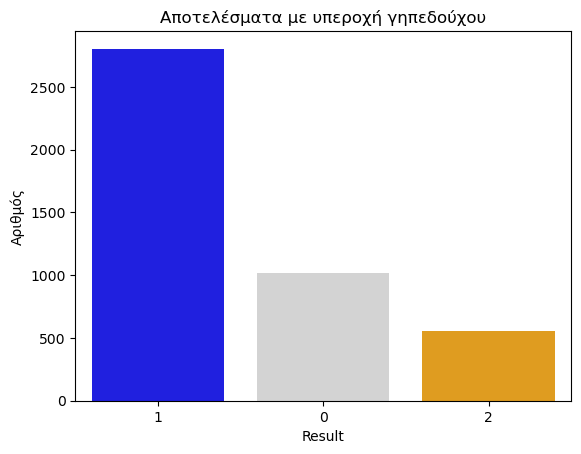

In [14]:
numbers = [num_xG_positive_1, num_xG_positive_0, num_xG_positive_2]
labels = ['1', '0', '2']
colors = ['blue', 'lightgrey', 'orange']

sns.barplot(x=labels, y=numbers, palette=colors)

plt.xlabel('Result')
plt.ylabel('Αριθμός')
plt.title('Αποτελέσματα με υπεροχή γηπεδούχου')

Η υπεροχή του γηπεδούχου επιβεβαιώθηκε και στο αποτέλεσμα σε 2804 αγώνες, δηλαδή στο 64% των αγώνων που ο γηπεδούχος είχε περισσότερα xGoals. Μπορούμε να πούμε ότι είναι ένα αρκετά ικανοποιητικό ποσοστό. <br>

Η υπεροχή του γηπεδούχου δεν επιβραβεύτηκε καθόλου σε 558 αγώνες από τους 4381, περίπου το 12.7%.

### 2. Οριακοί αγώνες (-0.2 ≤ xG_Difference ≤ 0.2)
Σύμφωνα με την KDE που αναδεικνύει την κατανομή των δεδομένων σε μια συνεχή κλίμακα τιμών, η μέγιστη τιμή της καμπύλης KDE βρίσκεται στο x=0.19. Για αυτόν τον λόγο, θα ορίσουμε τους οριακούς αγώνες στο πεδίο [-0.2, 0.2], δηλαδή -0.2 ≤ xG_Difference ≤0.2.

In [15]:
xG_zero = (data['xG_Difference'] >= -0.2) & (data['xG_Difference'] <= 0.2)
num_xG_zero = xG_zero.sum()
print("Αριθμός οριακών αγώνων:", num_xG_zero)

Αριθμός οριακών αγώνων: 1480


#### Νίκες γηπεδούχου σε οριακούς αγώνες

In [16]:
xG_zero_1 = data[(data['xG_Difference'] >= -0.2) & (data['xG_Difference'] <= 0.2) & (data.Result==1)]
num_xG_zero_1 = len(xG_zero_1)
print('Αριθμός νικών γηπεδούχου σε οριακούς αγώνες:', num_xG_zero_1)

Αριθμός νικών γηπεδούχου σε οριακούς αγώνες: 516


#### Ισοπαλίες σε οριακούς αγώνες

In [17]:
xG_zero_0 = data[(data['xG_Difference'] >= -0.2) & (data['xG_Difference'] <= 0.2) & (data.Result==0)]
num_xG_zero_0 = len(xG_zero_0)
print('Ισοπαλίες σε οριακούς αγώνες:', num_xG_zero_0)

Ισοπαλίες σε οριακούς αγώνες: 450


#### Νίκες φιλοξενούμενης σε οριακούς αγώνες

In [18]:
xG_zero_2 = data[(data['xG_Difference'] >= -0.2) & (data['xG_Difference'] <= 0.2) & (data.Result==2)]
num_xG_zero_2 = len(xG_zero_2)
print('Νίκες φιλοξενούμενης σε οριακούς αγώνες:', num_xG_zero_2)

Νίκες φιλοξενούμενης σε οριακούς αγώνες: 514


Text(0.5, 1.0, 'Αποτελέσματα οριακών αγώνων')

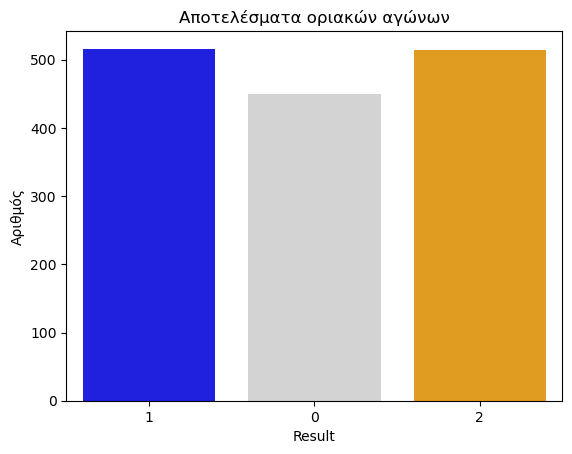

In [19]:
numbers = [num_xG_zero_1, num_xG_zero_0, num_xG_zero_2]
labels = ['1', '0', '2']
colors = ['blue', 'lightgrey', 'orange']

sns.barplot(x=labels, y=numbers, palette=colors)

plt.xlabel('Result')
plt.ylabel('Αριθμός')
plt.title('Αποτελέσματα οριακών αγώνων')

Παρατηρείται μια ισορροπημένη κατανομή των αποτελεσμάτων στους οριακούς αγώνες. <br> 
Ουσιαστικά προκύπτει το συμπέρασμα ότι όταν ο αγώνας είναι οριακός, το αποτέλεσμα μπορεί να είναι οποιοδήποτε. <br> 
Είναι αξιοσημείωτο οτί οι ισοπαλίες είναι λιγότερες από τα άλλα αποτελέσματα σε αυτήν τη συνθήκη.

### 3. Υπεροχή φιλοξενούμενου (xG_Difference<-0.2)

In [20]:
xG_negative = (data['xG_Difference'] < -0.2)
num_xG_negative = xG_negative.sum()
print("Αριθμός αγώνων με υπεροχή φιλοξενούμενης:", num_xG_negative)

Αριθμός αγώνων με υπεροχή φιλοξενούμενης: 2813


#### Υπεροχή φιλοξενούμενου αλλά νίκη γηπεδούχου (xG_Difference<-0.2 και Result=1)

In [21]:
xG_negative_1 = data[(data.xG_Difference<-0.2) & (data.Result==1)]
num_xG_negative_1 = len(xG_negative_1)
print('Αριθμός νικών γηπεδούχου παρόλο που είχε υπεροχή η φιλοξενούμενη:', num_xG_negative_1)

Αριθμός νικών γηπεδούχου παρόλο που είχε υπεροχή η φιλοξενούμενη: 492


#### Υπεροχή φιλοξενούμενου αλλά ισοπαλία (xG_Difference<-0.2 και Result=0)

In [22]:
xG_negative_0 = data[(data.xG_Difference<-0.2) & (data.Result==0)]
num_xG_negative_0 = len(xG_negative_0)
print('Αριθμός ισοπαλιών όταν είχε υπεροχή η φιλοξενούμενη:', num_xG_negative_0)

Αριθμός ισοπαλιών όταν είχε υπεροχή η φιλοξενούμενη: 684


#### Υπεροχή φιλοξενούμενου και νίκη φιλοξενούμενου (xG_Difference<-0.2 και Result=2)

In [23]:
xG_negative_2 = data[(data.xG_Difference<-0.2) & (data.Result==2)]
num_xG_negative_2 = len(xG_negative_2)
print('Αριθμός νικών φιλοξενούμενης όταν είχε υπεροχή:', num_xG_negative_2)

Αριθμός νικών φιλοξενούμενης όταν είχε υπεροχή: 1637


Text(0.5, 1.0, 'Αποτελέσματα με υπεροχή φιλοξενούμενης')

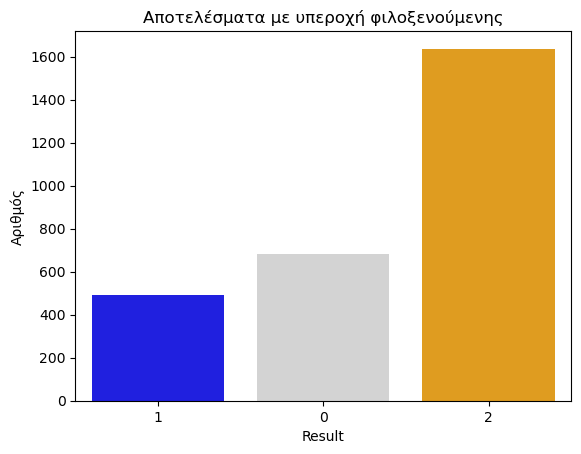

In [24]:
numbers = [num_xG_negative_1, num_xG_negative_0, num_xG_negative_2]
labels = ['1', '0', '2']
colors = ['blue', 'lightgrey', 'orange']

sns.barplot(x=labels, y=numbers, palette=colors)

plt.xlabel('Result')
plt.ylabel('Αριθμός')
plt.title('Αποτελέσματα με υπεροχή φιλοξενούμενης')

Η υπεροχή του φιλοξενούμενου επιβεβαιώθηκε και στο αποτέλεσμα σε 1637 αγώνες, δηλαδή περίπου στο 58.2% των αγώνων που ο φιλοξενούμενος είχε περισσότερα xGoals, το οποίο είναι ένα αρκετά καλό ποσοστό. <br>

Η υπεροχή του φιλοξενούμενου δεν επιβραβεύτηκε καθόλου σε 492 αγώνες από τους 2813, περίπου το 17.5%, ποσοστό που δεν θεωρείται μεγάλο αν ληφθεί υπόψη, ένας ανθρώπινος παράγοντας, ο παράγοντας της έδρας.

### "Δίκαια" και "άδικα" αποτελέσματα

Number of fair results: 4891
Number of unfair results: 3783


Text(0.5, 1.0, '"Δίκαια" και "άδικα" αποτελέσματα')

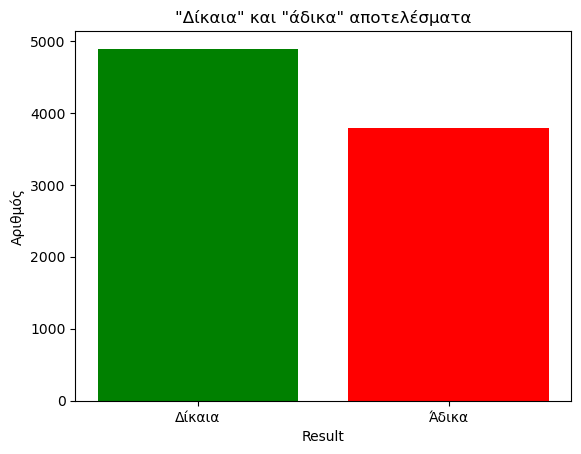

In [25]:
fair_results = num_xG_positive_1 + num_xG_zero_0 + num_xG_negative_2
unfair_results = (num_xG_positive_0 + num_xG_positive_2 + num_xG_zero_1 + num_xG_zero_2 + num_xG_negative_1 + num_xG_negative_0)

print("Number of fair results:", fair_results)
print("Number of unfair results:", unfair_results)

labels = ['Δίκαια', 'Άδικα']

values = [fair_results, unfair_results]
colors = ['green', 'red']

plt.bar(labels, values, color=colors)

plt.xlabel('Result')
plt.ylabel('Αριθμός')
plt.title('"Δίκαια" και "άδικα" αποτελέσματα')

Υπήρξε "δίκαιο" αποτέλεσμα σε 4891 από τους 8674 αγώνες, περίπου στο 56.4% των συνολικών αγώνων. <br> Λαμβάνοντας υπόψη και τους οριακούς αγώνες, προκύπτει το συμπέρασμα ότι η υπεροχή μιας ομάδας στα xGoals της δίνει μια αρκετά μεγάλη πιθανότητα να κερδίσει και τον αγώνα ή τουλάχιστον να μη χάσει.

# Ποιο μοντέλο κατηγοριοποίησης είναι περισσότερο ικανό να προβλέψει τα αποτελέσματα ποδοσφαιρικών αγώνων με βάση τα xGoals;

## Διαχωρισμός σε δεδομένα εκπαίδευσης και δεδομένα ελέγχου

X: Τα χαρακτηριστικά που θα χρησιμοποιηθούν ως είσοδοι στο μοντέλο <br>
y: Οι στήλες με τις ετικέτες για κάθε δείγμα ως έξοδοι του μοντέλου.

In [26]:
X = data['xG_Difference']
y = data['Result']

#### Χρήση του εργαλείου ``preprocessing`` της βιβλιοθήκης Scikit-learn για τη μετατροπή των κατηγορικών μεταβλητών 'xG_Difference' και 'Result' σε αριθμητικές μεταβλητές χρησιμοποιώντας τον LabelEncoder.

In [27]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
X = le.fit_transform(data['xG_Difference']) 
y = le.fit_transform(data['Result']) 

X = np.array(X).reshape((-1, 1))
X,y

(array([[55],
        [37],
        [38],
        ...,
        [37],
        [48],
        [57]], dtype=int64),
 array([1, 0, 2, ..., 2, 2, 1], dtype=int64))

#### Χρήση του εργαλείου ``train_test_split`` της βιβλιοθήκης Scikit-learn για την κατανομή των δεδομένων σε εκπαίδευσης και ελέγχου.

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=10)

In [29]:
print("X_train διαστάσεις:", X_train.shape)
print("y_train διαστάσεις:", y_train.shape)

print("X_test διαστάσεις:", X_test.shape)
print("y_test διαστάσεις:", y_test.shape)

X_train διαστάσεις: (6071, 1)
y_train διαστάσεις: (6071,)
X_test διαστάσεις: (2603, 1)
y_test διαστάσεις: (2603,)


# 1. Decision Trees

In [30]:
dtree = tree.DecisionTreeClassifier()

In [31]:
dtree.fit(X_train, y_train)

DecisionTreeClassifier()

In [32]:
y_pred = dtree.predict(X_test)

In [33]:
type(y_pred)

numpy.ndarray

## Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix')

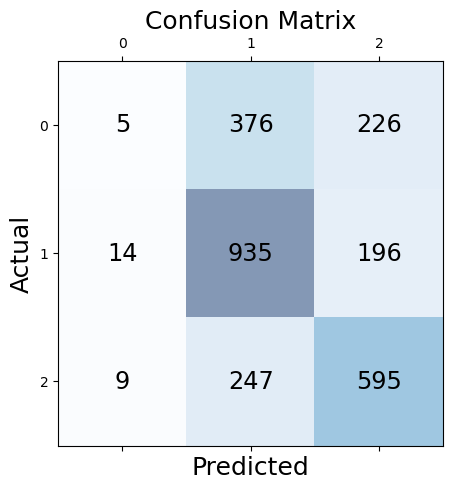

In [34]:
cm = confusion_matrix(y_test, y_pred)

# Confusion matrix με Matplotlib
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.5)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('Actual', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)

## Classification Report

In [35]:
from sklearn.metrics import classification_report
target_names = ['0', '1', '2']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.18      0.01      0.02       607
           1       0.60      0.82      0.69      1145
           2       0.59      0.70      0.64       851

    accuracy                           0.59      2603
   macro avg       0.45      0.51      0.45      2603
weighted avg       0.50      0.59      0.52      2603



## Καμπύλη ROC

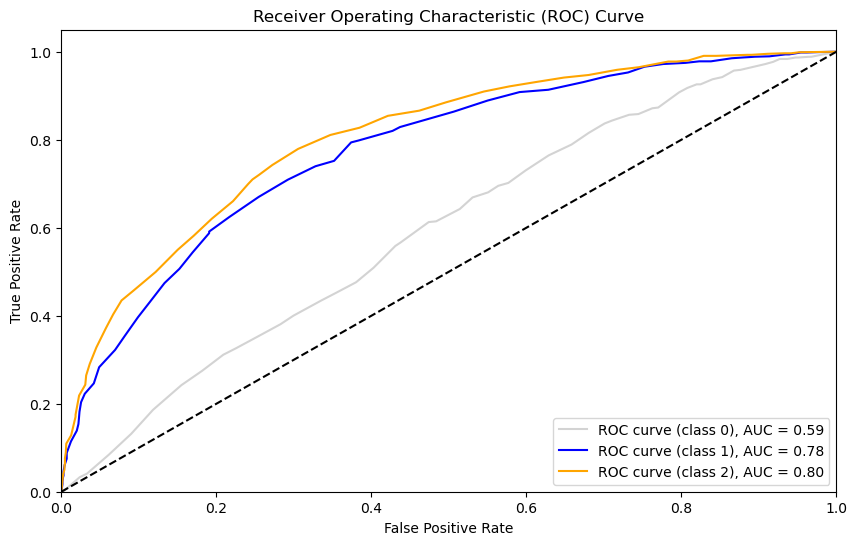

In [36]:
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

y_score = dtree.predict_proba(X_test)

n_classes = y_test_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 6))
colors = ['lightgrey', 'blue', 'orange']

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], label=f'ROC curve (class {i}), AUC = {roc_auc[i]:.2f}')

plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

## Cross-Validation

In [37]:
DT_Score = cross_val_score(
    dtree, X_train, y_train,
    cv=3, scoring='f1_weighted'
)

avg_DT_Score = DT_Score.mean()
print(f'Average Weighted F1 score: {avg_DT_Score:.3f}')

Average Weighted F1 score: 0.491


# 2. K-Nearest Neighbors

In [38]:
epidosiModelou = []
for k in range(1, 15):
    knnClass = KNeighborsClassifier(n_neighbors=k)
    knnClass.fit(X_train, y_train)
    pred = knnClass.predict(X_test)
    score = f1_score(y_test, pred, average='weighted')
    epidosiModelou.append(score)
print(f"H καλύτερη επίδοση είναι {max(epidosiModelou):.3f} για K = {epidosiModelou.index(max(epidosiModelou)) + 1}")

H καλύτερη επίδοση είναι 0.544 για K = 5


In [39]:
knnClass = KNeighborsClassifier(n_neighbors=5)

In [40]:
knnClass.fit(X_train, y_train)

KNeighborsClassifier()

In [41]:
y_pred = knnClass.predict(X_test)

In [42]:
type(y_pred)

numpy.ndarray

## Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix')

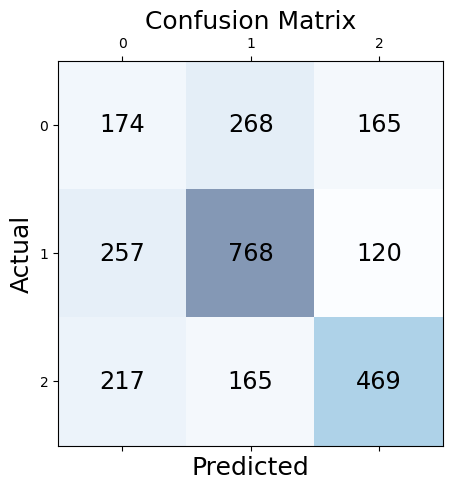

In [43]:
cm = confusion_matrix(y_test, y_pred)

# Confusion matrix με Matplotlib
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.5)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('Actual', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)

## Classification Report

In [44]:
from sklearn.metrics import classification_report
target_names = ['0', '1', '2']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.27      0.29      0.28       607
           1       0.64      0.67      0.65      1145
           2       0.62      0.55      0.58       851

    accuracy                           0.54      2603
   macro avg       0.51      0.50      0.51      2603
weighted avg       0.55      0.54      0.54      2603



## Καμπύλη ROC

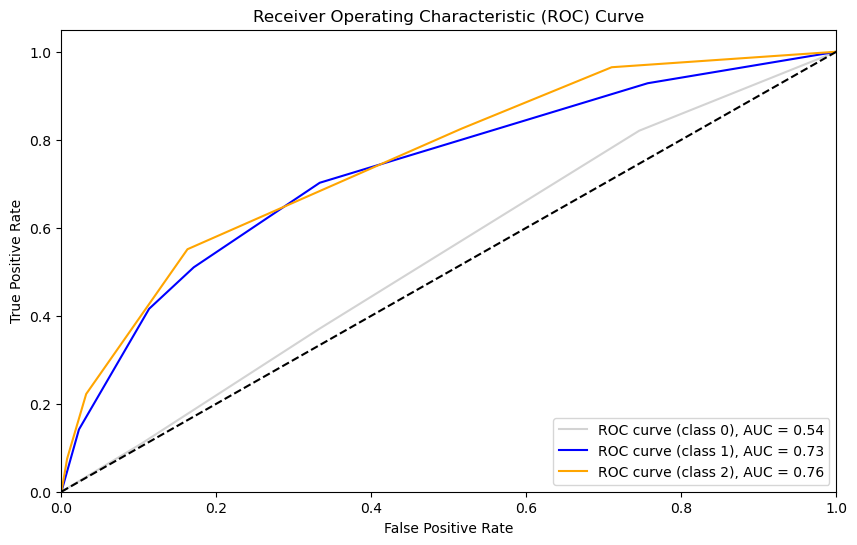

In [45]:
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

y_score = knnClass.predict_proba(X_test)

n_classes = y_test_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 6))
colors = ['lightgrey', 'blue', 'orange']

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], label=f'ROC curve (class {i}), AUC = {roc_auc[i]:.2f}')

plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

## Cross-Validation

In [46]:
knnScore = cross_val_score(
    knnClass, X_train, y_train,
    cv=11, scoring='f1_weighted'
)

avg_knnScore = knnScore.mean()
print(f'Average Weighted F1 score: {avg_knnScore:.3f}')

Average Weighted F1 score: 0.512


# 3. Random Forest

In [47]:
rfc = RandomForestClassifier(n_estimators=500, max_features=3)

In [48]:
rfc.fit(X_train, y_train)

RandomForestClassifier(max_features=3, n_estimators=500)

In [49]:
y_pred_test = rfc.predict(X_test)
y_pred_train = rfc.predict(X_train)

## Confusion Matrix

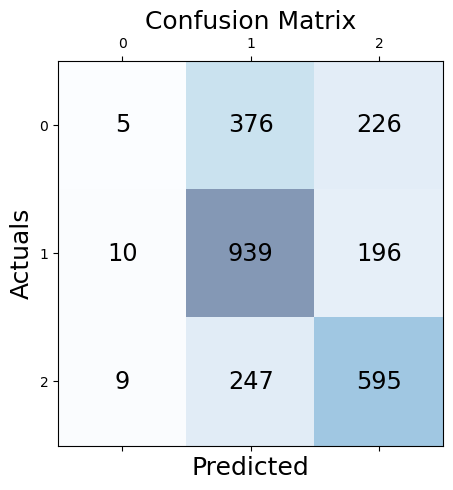

In [50]:
cm = confusion_matrix(y_test, y_pred_test)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.5)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

## Classification Report

In [51]:
target_names = ['0', '1', '2']
print(classification_report(y_test, y_pred_test, target_names=target_names))

              precision    recall  f1-score   support

           0       0.21      0.01      0.02       607
           1       0.60      0.82      0.69      1145
           2       0.59      0.70      0.64       851

    accuracy                           0.59      2603
   macro avg       0.46      0.51      0.45      2603
weighted avg       0.50      0.59      0.52      2603



## Καμπύλη ROC

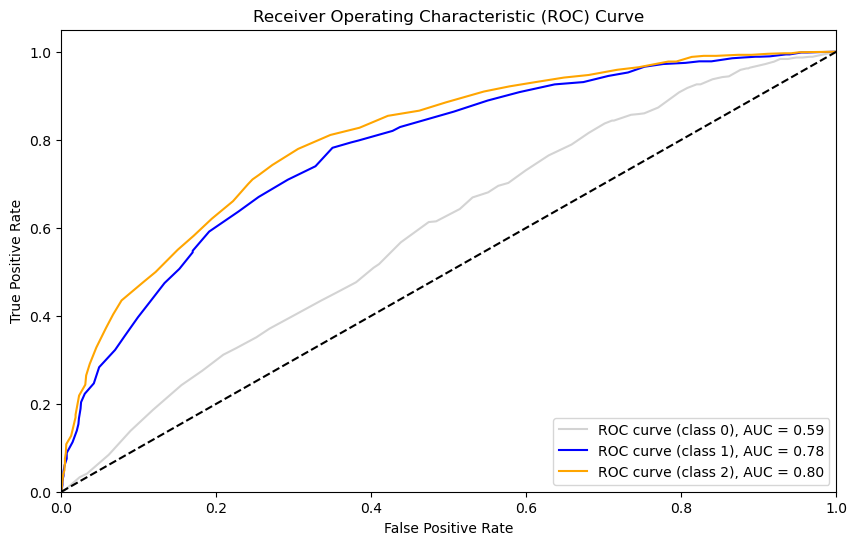

In [52]:
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

y_score = rfc.predict_proba(X_test)

n_classes = y_test_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 6))
colors = ['lightgrey', 'blue', 'orange']  

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], label=f'ROC curve (class {i}), AUC = {roc_auc[i]:.2f}')

plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

## Cross-Validation

In [53]:
RF_Score = cross_val_score(
    rfc, X_train, y_train,
    cv=3, scoring='f1_weighted'
)

avg_RF_Score = RF_Score.mean()
print(f'Average Weighted F1 score: {avg_RF_Score:.3f}')

Average Weighted F1 score: 0.491


# 4. Gaussian Naive Bayes Classifier

In [54]:
gnb = GaussianNB()

In [55]:
gnb.fit(X,y)

GaussianNB()

In [56]:
y_pred_test = gnb.predict(X_test)
y_pred_train = gnb.predict(X_train)

## Confusion Matrix

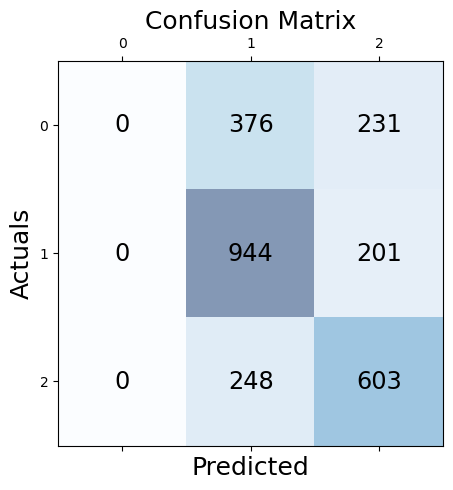

In [57]:
cm = confusion_matrix(y_test, y_pred_test)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.5)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

## Classification Report

In [58]:
target_names = ['0', '1', '2']
print(classification_report(y_test, y_pred_test, target_names=target_names, zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       607
           1       0.60      0.82      0.70      1145
           2       0.58      0.71      0.64       851

    accuracy                           0.59      2603
   macro avg       0.39      0.51      0.45      2603
weighted avg       0.46      0.59      0.52      2603



## Καμπύλη ROC

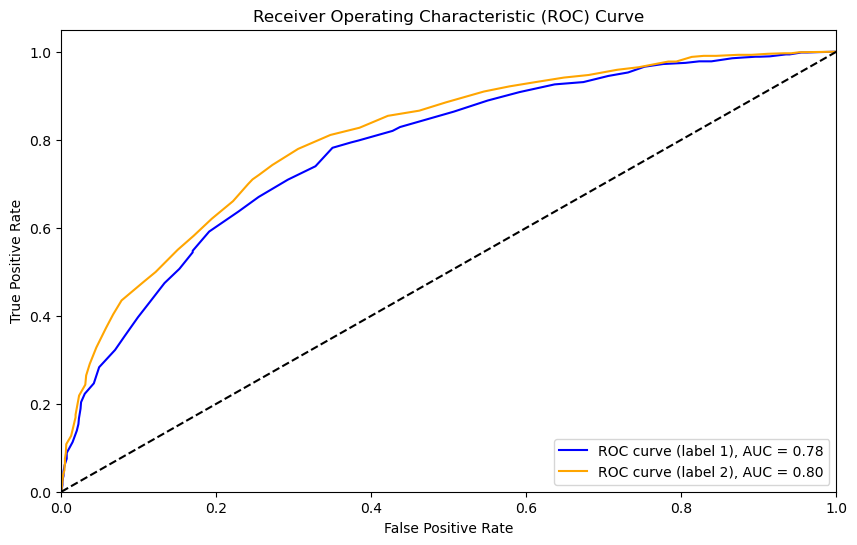

In [59]:
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = y_test_bin.shape[1]

for i in range(1, n_classes):  # Δε λαμβάνεται υπόψη το Result 0.
    
    y_test_label = y_test_bin[:, i]
    y_score_label = y_score[:, i]
    
    fpr[i], tpr[i], _ = roc_curve(y_test_label, y_score_label)
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 6))
colors = ['blue', 'orange']  

for i in range(1, n_classes):  # Δε λαμβάνεται υπόψη το Result 0.
    plt.plot(fpr[i], tpr[i], color=colors[i-1], label=f'ROC curve (label {i}), AUC = {roc_auc[i]:.2f}')

plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Cross-Validation

In [60]:
gnb_Score = cross_val_score(
    gnb, X_train, y_train,
    cv=3, scoring='f1_weighted'
)

avg_gnb_Score = gnb_Score.mean()
print(f'Average Weighted F1 score: {avg_gnb_Score:.3f}')

Average Weighted F1 score: 0.488
